In [1]:
import numpy as np
import scipy.io
from scipy.integrate import solve_ivp
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as mtransforms

# imports custom RNCRN functions that are used throughout multiple  notebooks 
import os, sys 
from pathlib import Path
module_path = str(Path(os.path.abspath('')).parent)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from functions.target_systems import homoclinic_bifurcation 
from functions.RNCRN_tools import load_tf_models_params, save_crn, convert_static_exec_RNCRN_params_to_CRN, read_crn_txt, new_initial_conditions, stoch_mat_to_mass_action

In [2]:
# loads the previously trained model for quasi-static analysis 
filename = 'models/homoclinic_example'
matcontents = scipy.io.loadmat(filename+'.mat')
first_layer_weights = matcontents['first_layer_weights']
first_layer_biases = matcontents['first_layer_biases'][0]
output_layer_weights = matcontents['output_layer_weights']
N = len(matcontents['first_layer_biases'][0])
gamma = matcontents['gamma'][0][0]
beta_1 = matcontents['beta'][0][0]
tau = matcontents['alpha'][0][0] # abuse of notation - but intentional
kernel_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_weights'])
bias_initializer_first = tf.keras.initializers.constant(matcontents['first_layer_biases'][0])
kernel_initializer_second = tf.keras.initializers.constant(matcontents['output_layer_weights'])

def smooth_max_activation(x):
    return 0.5*(x + K.sqrt(K.square(x)+4*gamma*tau))/tau
get_custom_objects().update({'smooth_max_activation': Activation(smooth_max_activation)})

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,), name=''),
  tf.keras.layers.Dense(N, activation='smooth_max_activation', kernel_initializer=kernel_initializer_first, bias_initializer=bias_initializer_first),
  tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_initializer = kernel_initializer_second),
])


In [3]:
# loads the previously trained model for compilation into a chemical reaction network (using helper functions)
params, number_of_exec_species, number_of_chemical_perceptrons = load_tf_models_params(filename+'.mat')

# define the number of parameter species 
number_of_control_params = 1

# define time-scale parameter to rescale appropriate rate constants in the chemical reaction network
time_scale = 0.0001

# creates zero initial conditions for all chemical species (will be overwritten later)
inits = np.zeros(number_of_exec_species+number_of_chemical_perceptrons)
control_inits = np.zeros(number_of_control_params)

# location to store the CRN file for this RNCRN 
crn_file = 'CRNs/homoclinic_crn.txt'

# converts RNCRN parameters into a chemical reaction network and saves as a raw txt file 
save_crn(crn_file,  convert_static_exec_RNCRN_params_to_CRN(params, time_scale, inits, control_inits, number_of_exec_species, number_of_chemical_perceptrons, number_of_control_params) )

# reads the previously saved chemical reaction network file returning the key stoichiometry and kinetic matrices 
species, reaction_rates, react_stoch, prod_stoch, stoch_mat, number_species, number_reactions, initial_concs = read_crn_txt(crn_file)

# groups stoichiometry matrices for use in ODE simulation 
args_tup_rncrn = (reaction_rates, react_stoch, stoch_mat,)

In [4]:
# sets the executive species domain  
xlower_limit = 4
xupper_limit = 5
ylower_limit = 3.5
yupper_limit = 5.5

param_lower_limit = 1.9
param_upper_limit = 2.1

step_size = 0.015;
step_size_par = 0.1;

# recall parameters used to shift the non-physical Hopf bifurication
a = 5;
r_critical = 2

# offset amount for exploring non-perfect approximations 
r_critical_shift = 1.997

# sets the time length for the trajectory simulations 
tFinal = 100;

# offset initial conditions for different trajectories (used later)
x1= 3.5
x2 = 6.0435 
x2_prime = 6.04
x2_a = 6.0

In [5]:
# numerical integrations of trajectories for the target system (shifted homoclinic orbit) and the RNCRN approximation  
# these trajectories correspond to trajectories in Figure 2 (c)--(d)
# - TARGET SYSTEM

# offset initial conditions for different trajectories (used later)
x1= 3.5
x2 = 6.0435 
x2_prime = 6.04
x2_a = 6.0

#\lambda_bar_1 = 1.9
inits = [x1, x2_a];
args_tup = (a, r_critical, 1.9)
sol_1= solve_ivp(homoclinic_bifurcation, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_bar_1 = 1.9
inits = [x1, x2_a];
args_tup = (a,r_critical, 1.9)
sol_1b= solve_ivp(homoclinic_bifurcation, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_1 = 1.9
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':x1, 'X_2': x2_a, 'L_1': 1.9})
sol_rncrn_1 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-20)

#\lambda_1 = 1.9
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':3.5, 'X_2': 5.6, 'L_1': 1.9})
sol_rncrn_1b = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

#\lambda_bar_1 = 2
args_tup = (a,r_critical, 2)
inits = [x1, x2];
sol_2= solve_ivp(homoclinic_bifurcation, [0, tFinal], inits, args=args_tup, rtol=10e-20)

#\lambda_1 = 1.997
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':x1, 'X_2': x2_prime, 'L_1': r_critical_shift})
sol_rncrn_2 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-20)

#\lambda_bar_1 = 2.1
args_tup = (a,r_critical, 2.1)
inits = [x1, x2];
sol_3= solve_ivp(homoclinic_bifurcation, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_bar_1 = 2.1
inits = [4.8, 4.3];
sol_3b= solve_ivp(homoclinic_bifurcation, [0, tFinal], inits, args=args_tup, rtol=10e-8)

#\lambda_1 = 2.1
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':x1, 'X_2': x2, 'L_1': 2.1})
sol_rncrn_3 = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

#\lambda_1 = 2.1
inits_rncrn, id_dict = new_initial_conditions(initial_concs, species, {'X_1':4.8, 'X_2': 4.3, 'L_1': 2.1})
sol_rncrn_3b = solve_ivp(stoch_mat_to_mass_action, [0, tFinal], inits_rncrn, args=args_tup_rncrn, rtol=10e-8)

C:\Users\ad1114\AppData\Local\miniconda3\envs\tf\lib\site-packages\scipy\integrate\_ivp\common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


In [6]:
# Vector fields for the target system (shifted homoclinic orbit) and the quasi-static vector field for the RNCRN approximation  
# these vector fields correspond to the gray arrows in Figure 2 (c)--(d)

lower_limit = 3
upper_limit = 7

vis_step = 0.25;
x1_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")
x2_train = np.arange(lower_limit, upper_limit, vis_step, dtype="float32")

# \lambda_bar_1 = 1.9 for target system vector field 
lambda_1 = -0.1 + r_critical
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
g_1 = (x3v-r_critical-(4/5))*(x1v-a)+(x2v-a)-(6/5)*(x1v-a)*(x2v-a)+(3/2)*np.power((x2v-a),2)
g_2 = (x1v-a) -(4/5)*(x2v-a) - (4/5)*np.power((x2v-a),2)
target_vf_x1_1 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_1 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_1 = 1.9 for quasi-static RNCRN vector field
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_1 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

# \lambda_bar_1 = 2 for target system vector field 
lambda_1 = r_critical
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
g_1 = (x3v-r_critical-(4/5))*(x1v-a)+(x2v-a)-(6/5)*(x1v-a)*(x2v-a)+(3/2)*np.power((x2v-a),2)
g_2 = (x1v-a) -(4/5)*(x2v-a) - (4/5)*np.power((x2v-a),2)
target_vf_x1_2 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_2 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_1 = 1.997 for quasi-static RNCRN vector field
lambda_1 = r_critical_shift
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_2 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_2 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

# \lambda_bar_1 = 2.1 for target system vector field 
lambda_1 = 0.1 + r_critical
x3_train = np.array([lambda_1])
x1v, x2v, x3v = np.meshgrid(x1_train, x2_train, x3_train, indexing='ij')
g_1 = (x3v-r_critical-(4/5))*(x1v-a)+(x2v-a)-(6/5)*(x1v-a)*(x2v-a)+(3/2)*np.power((x2v-a),2)
g_2 = (x1v-a) -(4/5)*(x2v-a) - (4/5)*np.power((x2v-a),2)
target_vf_x1_3 = np.transpose(g_1.reshape(g_1.shape[0],g_1.shape[1]))
target_vf_x2_3 = np.transpose(g_2.reshape(g_1.shape[0],g_1.shape[1]))

# \lambda_1 = 2.1 for quasi-static RNCRN vector field
x_train =  np.concatenate( (x1v.reshape(-1,1), x2v.reshape(-1,1), x3v.reshape(-1,1)), axis=1)
y_out = model.predict(x_train);
U_out = y_out.reshape(g_1.shape[0], g_1.shape[1], 2)
res_x1_3 =  beta_1 + np.transpose(np.multiply(U_out[:,:,0], x1v.reshape( g_1.shape[0], g_1.shape[1])))
res_x2_3 =  beta_1 + np.transpose(np.multiply(U_out[:,:,1], x2v.reshape(g_2.shape[0], g_2.shape[1])))

8/8 [==============================] - 0s 858us/step


C:\Users\ad1114\AppData\Local\Temp\ipykernel_18352\794339189.py:125: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


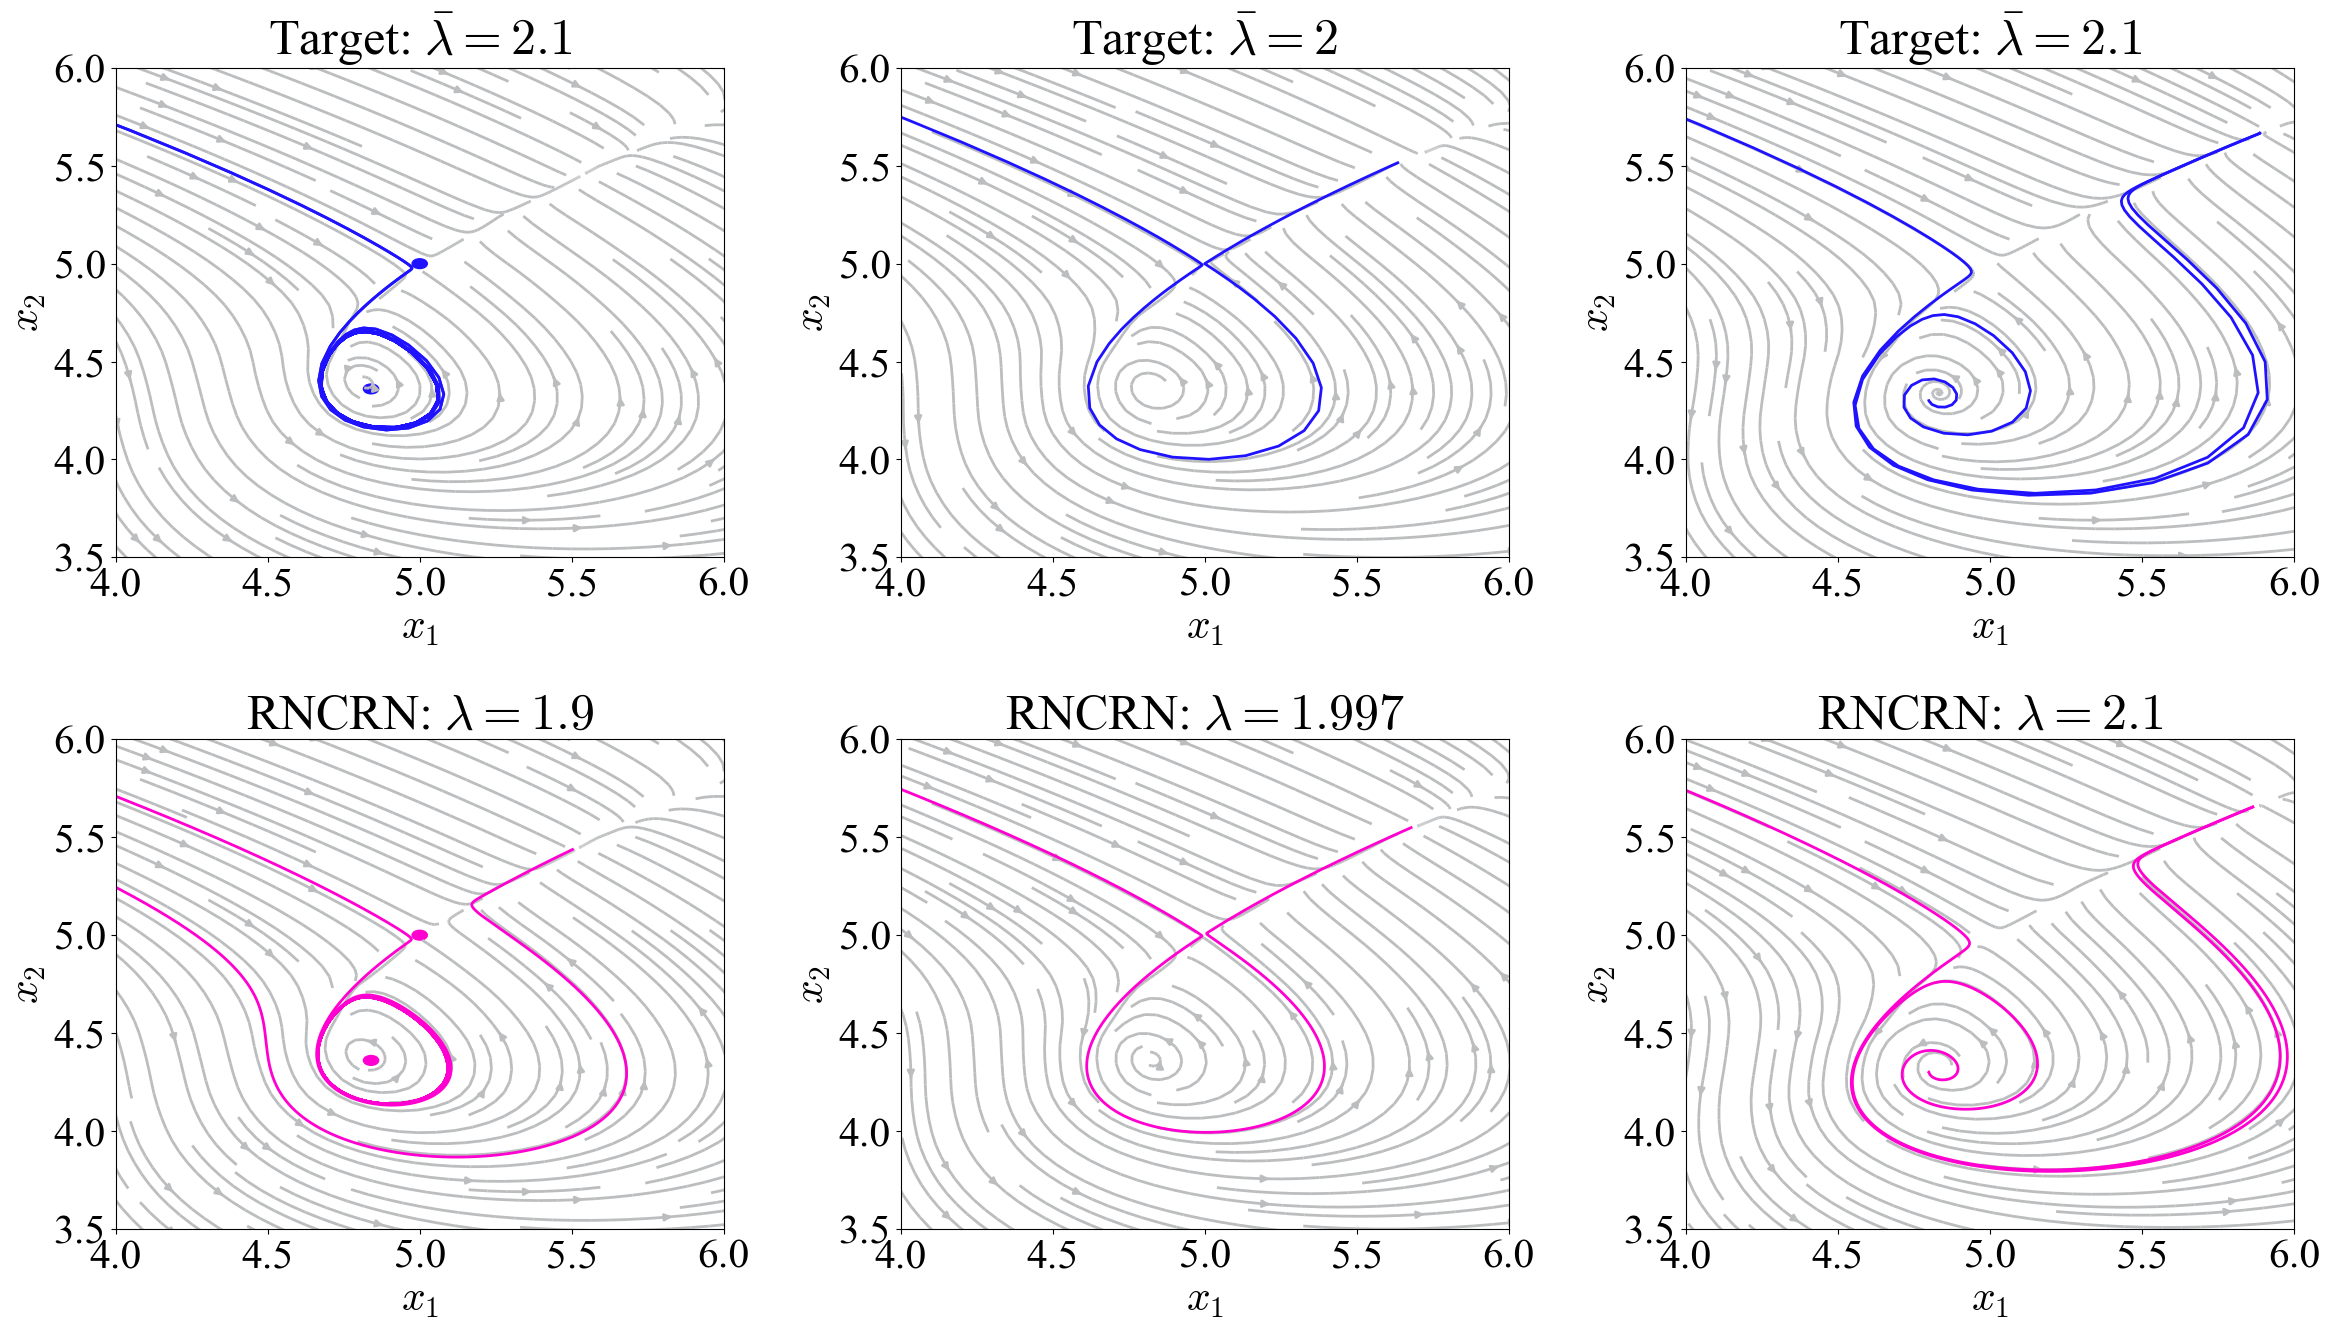

In [17]:
# plot some figures for visualisation  of the target system and RNCRN approximation  
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 30
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = [20 , 12]
mpl.rcParams['text.usetex'] = False
mpl.rcParams['legend.edgecolor'] = 'k'
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = False
ColList = ['#1F13FF','#FF00D0', '#2A2A72', '#A9A9A9']

mpl.rcParams['figure.figsize'] = [24, 14]

fig, axs = plt.subplot_mosaic([['(g)', '(h)', '(i)'],['(j)', '(k)', '(l)'],],  gridspec_kw={'width_ratios':[1,1,1]}, layout='constrained')

stablefp = 'limegreen'
linestyle_nodes = '-'
ColList = ['#1F13FF', '#FF00D0', '#2A2A72', '#bbbdbf','#FFAD1F']

mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30

tickfontsize=30
labelfontsize=35
titlefontsize=35  
legendfontsize = 20;
markersizeval = 10  
x1low = 4
x1high = 6

x2low = 3.5
x2high = 6

density = 1.5

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-40/72, 14/72, fig.dpi_scale_trans)
    #ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
    #        fontsize='medium', va='bottom', fontfamily='serif', ha='right')


circle_blue  = plt.Circle((a, a), 0.025, color=ColList[0])
circle_blue2  = plt.Circle((4.84, 4.36), 0.025, color=ColList[0])
circle_pink  = plt.Circle((a, a), 0.025, color=ColList[1])
circle_pink2  = plt.Circle((4.84, 4.36), 0.025, color=ColList[1])

axa = axs['(g)']
axa.streamplot(x1_train, x2_train,target_vf_x1_1,target_vf_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axa.set_xlim(lower_limit+0.5, upper_limit-0.5)
axa.set_ylim(lower_limit+0.5, upper_limit-0.5)
axa.plot(sol_1.y[0,:], sol_1.y[1,:], color=ColList[0], )
axa.plot(sol_1b.y[0,:], sol_1b.y[1,:], color=ColList[0], )
axa.set_title('Target: $\\bar{\lambda}=2.1$')
axa.set_xlabel('$x_1$')
axa.set_ylabel('$x_2$')
axa.add_patch(circle_blue)
axa.add_patch(circle_blue2)
axa.set_xlim(x1low, x1high)
axa.set_ylim(x2low, x2high)

axb = axs['(h)']
axb.streamplot(x1_train, x2_train,target_vf_x1_2,target_vf_x2_2,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axb.set_xlim(lower_limit+0.5, upper_limit-0.5)
axb.set_ylim(lower_limit+0.5, upper_limit-0.5)
axb.plot(sol_2.y[0,:], sol_2.y[1,:], color=ColList[0], )
axb.set_title('Target: $\\bar{\lambda}=2$')
axb.set_xlabel('$x_1$')
axb.set_ylabel('$x_2$')
axb.set_xlim(x1low, x1high)
axb.set_ylim(x2low, x2high)

axc = axs['(i)']
axc.streamplot(x1_train, x2_train,target_vf_x1_3,target_vf_x2_3,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axc.set_xlim(lower_limit+0.5, upper_limit-0.5)
axc.set_ylim(lower_limit+0.5, upper_limit-0.5)
axc.plot(sol_3.y[0,:], sol_3.y[1,:], color=ColList[0], )
axc.plot(sol_3b.y[0,:], sol_3b.y[1,:], color=ColList[0], )
axc.set_title('Target: $\\bar{\lambda}=2.1$')
axc.set_xlabel('$x_1$')
axc.set_ylabel('$x_2$')
axc.set_xlim(x1low, x1high)
axc.set_ylim(x2low, x2high)

axd = axs['(j)']
axd.streamplot(x1_train, x2_train, res_x1_1, res_x2_1,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axd.plot(sol_rncrn_1.y[id_dict['X_1'],:], sol_rncrn_1.y[id_dict['X_2'],:], color=ColList[1], )
axd.plot(sol_rncrn_1b.y[id_dict['X_1'],:], sol_rncrn_1b.y[id_dict['X_2'],:], color=ColList[1], )
axd.set_xlim(lower_limit+0.5, upper_limit-0.5)
axd.set_ylim(lower_limit+0.5, upper_limit-0.5)
axd.set_xlabel('$x_1$')
axd.set_ylabel('$x_2$')
axd.set_title('RNCRN: $\lambda=1.9$')
axd.add_patch(circle_pink)
axd.add_patch(circle_pink2)
axd.set_xlim(x1low, x1high)
axd.set_ylim(x2low, x2high)

axe = axs['(k)']
axe.streamplot(x1_train, x2_train, res_x1_2, res_x2_2,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axe.plot(sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:], color=ColList[1], )
axe.set_xlim(lower_limit+0.5, upper_limit-0.5)
axe.set_ylim(lower_limit+0.5, upper_limit-0.5)
axe.set_xlabel('$x_1$')
axe.set_ylabel('$x_2$')
axe.set_title('RNCRN: $\lambda=1.997$')
axe.set_xlim(x1low, x1high)
axe.set_ylim(x2low, x2high)

axf = axs['(l)']
axf.streamplot(x1_train, x2_train, res_x1_3, res_x2_3,  arrowstyle='-|>', color=ColList[3], linewidth=2, density=2)
axf.plot(sol_rncrn_3.y[id_dict['X_1'],:], sol_rncrn_3.y[id_dict['X_2'],:], color=ColList[1], )
axf.plot(sol_rncrn_3b.y[id_dict['X_1'],:], sol_rncrn_3b.y[id_dict['X_2'],:], color=ColList[1], )
axf.set_xlim(lower_limit+0.5, upper_limit-0.5)
axf.set_ylim(lower_limit+0.5, upper_limit-0.5)
axf.set_xlabel('$x_1$')
axf.set_ylabel('$x_2$')
axf.set_title('RNCRN: $\lambda=2.1$')
axf.set_xlim(x1low, x1high)
axf.set_ylim(x2low, x2high)

plt.tight_layout()
plt.show()
fig.savefig('figures/homoclinic_bifurcation.pdf', bbox_inches='tight')

In [8]:
#traj data
np.savetxt("data/homoclinic_traj_data_target_1.csv", np.asarray([ sol_1.t[:], sol_1.y[0,:], sol_1.y[1,:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_target_1b.csv", np.asarray([ sol_1b.t[:], sol_1b.y[0,:], sol_1b.y[1,:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_target_2.csv", np.asarray([ sol_2.t[:], sol_2.y[0,:], sol_2.y[1,:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_target_3.csv", np.asarray([ sol_3.t[:], sol_3.y[0,:], sol_3.y[1,:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_target_3b.csv", np.asarray([ sol_3b.t[:], sol_3b.y[0,:], sol_3b.y[1,:]]), delimiter=",")


np.savetxt("data/homoclinic_traj_data_rncrn_1.csv", np.asarray([sol_rncrn_1.t[:], sol_rncrn_1.y[id_dict['X_1'],:], sol_rncrn_1.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_rncrn_1b.csv", np.asarray([ sol_rncrn_1b.t[:], sol_rncrn_1b.y[id_dict['X_1'],:], sol_rncrn_1b.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_rncrn_2.csv", np.asarray([ sol_rncrn_2.t[:], sol_rncrn_2.y[id_dict['X_1'],:], sol_rncrn_2.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_rncrn_3.csv", np.asarray([ sol_rncrn_3.t[:], sol_rncrn_3.y[id_dict['X_1'],:], sol_rncrn_3.y[id_dict['X_2'],:]]), delimiter=",")
np.savetxt("data/homoclinic_traj_data_rncrn_3b.csv", np.asarray([ sol_rncrn_3b.t[:], sol_rncrn_3b.y[id_dict['X_1'],:], sol_rncrn_3b.y[id_dict['X_2'],:]]), delimiter=",")



np.savetxt("data/homoclinic_x1_train.csv", x1_train, delimiter=",")
np.savetxt("data/homoclinic_x2_train.csv", x2_train, delimiter=",")

#target vfs
np.savetxt("data/homoclinic_target_vf_x1_1.csv", target_vf_x1_1, delimiter=",")
np.savetxt("data/homoclinic_target_vf_x2_1.csv", target_vf_x2_1, delimiter=",")
np.savetxt("data/homoclinic_target_vf_x1_2.csv", target_vf_x1_2, delimiter=",")
np.savetxt("data/homoclinic_target_vf_x2_2.csv", target_vf_x2_2, delimiter=",")
np.savetxt("data/homoclinic_target_vf_x1_3.csv", target_vf_x1_3, delimiter=",")
np.savetxt("data/homoclinic_target_vf_x2_3.csv", target_vf_x2_3, delimiter=",")

#RNCRN quasi-static vfs
np.savetxt("data/homoclinic_res_x1_1.csv", res_x1_1, delimiter=",")
np.savetxt("data/homoclinic_res_x2_1.csv", res_x2_1, delimiter=",")
np.savetxt("data/homoclinic_res_x1_2.csv", res_x1_2, delimiter=",")
np.savetxt("data/homoclinic_res_x2_2.csv", res_x2_2, delimiter=",")
np.savetxt("data/homoclinic_res_x1_3.csv", res_x1_3, delimiter=",")
np.savetxt("data/homoclinic_res_x2_3.csv", res_x2_3, delimiter=",")


In [9]:
alpha_mat, omega_mat, bias_vec, beta, gamma, tau = params
print('omega_1')
for val in omega_mat[:,0]:
    print(f'{val:.3f}', '\\\\')

print('omega_2')
for val in omega_mat[:,1]:
    print(f'{val:.3f}', '\\\\')
    
print('psi_1')
for val in omega_mat[:,2]:
    print(f'{val:.3f}', '\\\\')
    
print('alpha_mat_1')
for val in alpha_mat[0,:]:
    print(f'{val:.3f}', '\\\\')

print('alpha_mat_2')
for val in alpha_mat[1,:]:
    print(f'{val:.3f}', '\\\\')
    
print('bias_vec')
for val in bias_vec:
    print(f'{val[0]:.3f}', '\\\\')

print('gamma')
print(gamma)

print('tau')
print(tau)

omega_1
0.372 \\
-0.183 \\
-0.205 \\
0.448 \\
-0.986 \\
-0.056 \\
-0.763 \\
1.043 \\
-0.253 \\
0.271 \\
omega_2
-0.697 \\
0.084 \\
0.835 \\
-1.034 \\
0.797 \\
-1.153 \\
0.025 \\
-0.515 \\
-0.296 \\
0.335 \\
psi_1
0.364 \\
-0.022 \\
-0.781 \\
-0.085 \\
0.062 \\
-0.023 \\
0.586 \\
-0.556 \\
0.323 \\
0.385 \\
alpha_mat_1
0.307 \\
-0.533 \\
0.324 \\
0.999 \\
4.348 \\
1.820 \\
-2.823 \\
-0.744 \\
-1.270 \\
0.837 \\
alpha_mat_2
0.812 \\
0.923 \\
-0.425 \\
-0.260 \\
-0.191 \\
-2.821 \\
-0.174 \\
0.228 \\
-0.349 \\
-0.636 \\
bias_vec
0.790 \\
1.455 \\
-1.391 \\
3.440 \\
-1.901 \\
3.461 \\
0.657 \\
0.634 \\
1.932 \\
-3.335 \\
gamma
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
tau
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [10]:
# Approximate quasi-static error
print('(x1, r=-0.1)', np.mean(np.square(target_vf_x1_1-res_x1_1)))
print('(x2, r=-0.1)', np.mean(np.square(target_vf_x2_1-res_x2_1)))

print('(x1, r=0)', np.mean(np.square(target_vf_x1_2-res_x1_2)))
print('(x2, r=0)', np.mean(np.square(target_vf_x2_2-res_x2_2)))

print('(x1, r=0.1)', np.mean(np.square(target_vf_x1_3-res_x1_3)))
print('(x2, r=0.1)', np.mean(np.square(target_vf_x2_3-res_x2_3)))

(x1, r=-0.1) 0.0026245846905276473
(x2, r=-0.1) 0.00034024508
(x1, r=0) 0.0022300482494655135
(x2, r=0) 0.00037639966
(x1, r=0.1) 0.0020055493943735613
(x2, r=0.1) 0.00040442636
